## Self

In [ ]:
# import pandas as pd 
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = []
features = ["Longitudinal position of the center of buoyancy",
            "Prismatic coefficient",
            "Length-displacement ratio",
            "Beam-draught ratio",
            "Length-beam ratio",
            "Froude number",
            "Residuary resistance per unit weight of displacement"]
with open("/content/drive/MyDrive/Colab Notebooks/Lab 1/yacht_hydrodynamics.data", 'r') as lines:
  for line in lines:
    data_point = line.split()
    data_point = [float(element) for element in data_point] # Bước này có thể làm bằng pandas (astype())
    if len(data_point) < 7: # Loại bỏ các data bị thiếu số liệu (xử lýtlýt)
      break
    data.append(data_point)

In [ ]:
data = np.array(data)

In [ ]:
data.shape

(308, 7)

In [ ]:
X_data = data[:, :6]
y_data = data[:, 6]

In [ ]:
# scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_data)
X_data = scaler.fit_transform(X_data)

In [ ]:
X_data

array([[0.54      , 0.54285714, 0.55      , 0.46456693, 0.48351648,
        0.        ],
       [0.54      , 0.54285714, 0.55      , 0.46456693, 0.48351648,
        0.07692308],
       [0.54      , 0.54285714, 0.55      , 0.46456693, 0.48351648,
        0.15384615],
       ...,
       [0.54      , 1.        , 0.        , 0.55905512, 0.        ,
        0.84615385],
       [0.54      , 1.        , 0.        , 0.55905512, 0.        ,
        0.92307692],
       [0.54      , 1.        , 0.        , 0.55905512, 0.        ,
        1.        ]])

## Task 1

In [ ]:
# KNNKNN
def find_neighbors(k_neighbors, X, center ):
  neighbors = []
  for i in range(len(X)):
    distance = np.linalg.norm(np.square(X[i] - center), axis=1)
    weight = np.exp(-distance**2/ 0.5**2 )
    neighbors.append([i, weight]) 
  neighbors = sorted(neighbors, key = lambda x : -x[1])

  return neighbors[0:k_neighbors] # return k neighbors 
  
def KNiegborRegressor(k_neighbors, X, y, center):
  neighbors = find_neighbors(k_neighbors, X, center)
  y_arr = [y[point[0]] for point in neighbors]
  avg_y = np.mean(y_arr)
  return avg_y


def distNeighbours(X_train,Y_train,X_test,K):
    distance=[]
    for i in range(len(X_train)):
        eDistance=0
        for j in range(X_train.shape[1]):   
                eDistance+=round(np.sqrt(pow((X_train[i,j]-X_test[j]),2)),2)
        distance.append((eDistance,i,Y_train[i]))
        distance=sorted(distance, key=lambda x: x[0])[0:K]
    return distance

def KNN_ParzenWindows(X_train,Y_train,X_test,K):
    neighbours=[]
    responses=[]
    for i in range(len(X_test)):
        neighbours.append(distNeighbours(X_train,Y_train,X_test[i,:],K))
    for i in neighbours:
        mean=0
        for j in i:
            mean+=j[-1]
        mean=mean/K
        responses.append(mean)
    return responses


# Predict GPA
from sklearn.model_selection import train_test_split
from sklearn import metrics


X_train, X_test, Y_train, Y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=69)
# Predict GPA
output=KNN_ParzenWindows(X_train,Y_train,X_test,3)
print('MSE from the code: {:^0.2f}'.format(metrics.mean_squared_error(Y_test,output),2))

MSE from the code: 103.76


R² score, the coefficient of determination:

If $\hat{y}_i$ is the predicted value of the $i$-th sample and $y_i$ is the corresponding true value for total $n$ samples, the estimated R² is defined as:

$R^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$

where $\bar{y} = \frac{1}{n} \sum_{i=1}^{n} y_i$ and $\sum_{i=1}^{n} (y_i - \hat{y}_i)^2 = \sum_{i=1}^{n} \epsilon_i^2$

Note that r2_score calculates unadjusted R² without correcting for bias in sample variance of y.

In [ ]:
# Evaluate 
from sklearn.metrics import r2_score
print(f"R² score: {r2_score(Y_test,output)}")

R² score: 0.5399275420897462


### Task 2 

### a: Try to tune parameter ‘k' and estimate classification or regression quality metrics

In [ ]:
!pip3 install matplotlib

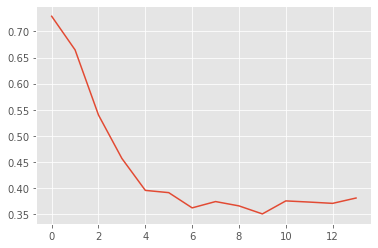

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
r2 = []
# train
for i in range(1, 15):
  output = KNN_ParzenWindows(X_train,Y_train,X_test,i)
  r2.append(r2_score(Y_test,output))
plt.plot(r2)


In [ ]:
### we have best k at n=6
output = KNN_ParzenWindows(X_train,Y_train,X_test,6)
print(r2_score(Y_test,output))

0.3913019456210386


### b: Implement Leave-one-out algorithm and find optimal hyperparameter ‘k' value

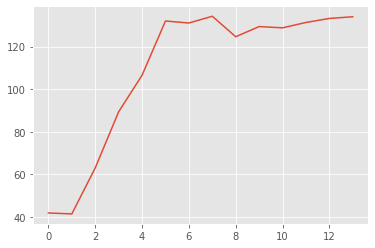

In [ ]:
import matplotlib.pyplot as plt
import warnings
import sklearn.exceptions

warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

plt.style.use("ggplot")
r2 = []
# train
for i in range(1, 15):
    
    r2_sum = 0
    for j in range(len(X_data)):
        
        X_train = np.delete(X_data, j, 0)
        Y_train = np.delete(y_data, j, 0)
        X_test = X_data[j][np.newaxis, :]
        Y_test = y_data[j]
        # print(X_train.shape, X_test.shape)
        output = KNN_ParzenWindows(X_train,Y_train,X_test, i)
        r2_sum += metrics.mean_squared_error([Y_test], output)
    r2.append(r2_sum/len(X_data))
plt.plot(r2)

In [ ]:
### i got nan with r2_score because LOO only have 1 sample. so change the loss to MSE
## best value is k=5
X_train, X_test, Y_train, Y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=69)

output = KNN_ParzenWindows(X_train,Y_train,X_test,5)
print(r2_score(Y_test,output))

0.3956182534450441


### c:	For optimal ‘k' value compare your implementation with scikit-learn version of the kNN algorithm

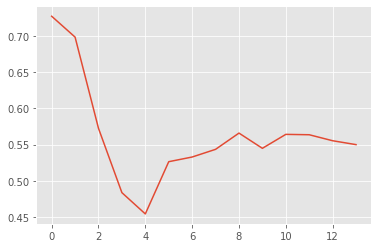

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
import matplotlib.pyplot as plt
plt.style.use("ggplot")
r2 = []
# train

for i in range(1, 15):
  model = KNeighborsRegressor(n_neighbors=i).fit(X_train,Y_train)
  output = model.predict(X_test)
  r2.append(r2_score(Y_test,output))
plt.plot(r2)



In [ ]:
## Best k is at n=4
model = KNeighborsRegressor(n_neighbors=i).fit(X_train,Y_train)
output = model.predict(X_test)
print(r2_score(Y_test,output))

0.549958626277703


### Our model have lower r2_score and better peformance.